# Core Imports and Setup

In [1]:
import os
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

import logging
# logging.basicConfig(level=logging.DEBUG)
logging.getLogger("openff.toolkit").setLevel(logging.ERROR)

from openff import toolkit, evaluator

import pandas as pd
import json

In [2]:
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase
from openff.evaluator.datasets.thermoml import thermoml_property
from openff.evaluator import properties
from openff.units import unit

In [3]:
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase
from openff.evaluator.datasets.thermoml import thermoml_property
from openff.units import unit
from openff.evaluator.datasets.thermoml import ThermoMLDataSet
from openff.evaluator.datasets.thermoml.thermoml import _Compound
from openff.toolkit import Molecule
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

# 0) Registering Custom ThermoML Properties

In [4]:
@thermoml_property("Osmotic coefficient", supported_phases=PropertyPhase.Liquid | PropertyPhase.Gas)
class OsmoticCoefficient(PhysicalProperty):
    """A class representation of a osmotic coeff property"""

    @classmethod
    def default_unit(cls):
        return unit.dimensionless
    
setattr(properties, OsmoticCoefficient.__name__, OsmoticCoefficient)

# 1) - Loading ThermoML Data Sets

### Testing OpenEye (and other) chemical resolvers

In [5]:
# smi = 'C([C@@H]1[C@@H]2[C@@H]([C@H]([C@H](O1)O[C@@H]3[C@H](O[C@@H]([C@@H]([C@H]3O)O)O[C@@H]4[C@H](O[C@@H]([C@@H]([C@H]4O)O)O[C@@H]5[C@H](O[C@@H]([C@@H]([C@H]5O)O)O[C@@H]6[C@H](O[C@@H]([C@@H]([C@H]6O)O)O[C@@H]7[C@H](O[C@H](O2)[C@@H]([C@H]7O)O)CO)CO)CO)CO)CO)O)O)O'
# Chem.MolFromSmiles(smi)

In [6]:
import cirpy

cirpy.resolve('1,4-benzenediol', 'smiles')

'Oc1ccc(O)cc1'

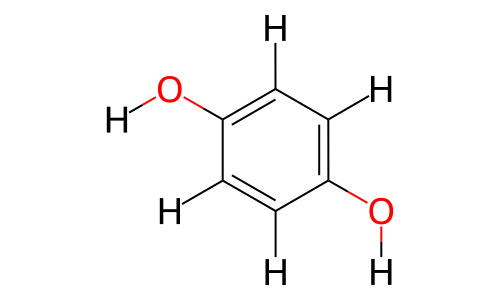

In [7]:
mol=Molecule.from_iupac('1,4-benzenediol')
mol.visualize()

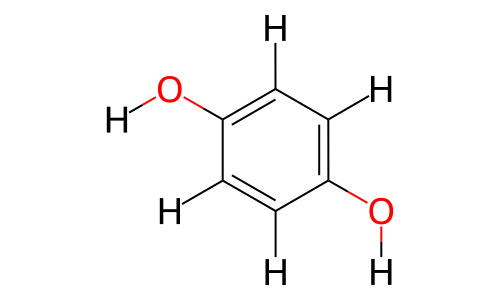

In [8]:
mol = Molecule.from_iupac('1,4-benzenediol')
mol.visualize()

In [9]:
import pubchempy as pcp

In [10]:
# pcp.get_compounds('p-quinol', namespace='iupac_name')

### Custom query over ThermoML xml

In [11]:
import requests
from urllib.error import HTTPError
from xml.etree import ElementTree


doi = '10.1021/je800307g'
url = f"https://trc.nist.gov/ThermoML/{doi}.xml"
try:
    request = requests.get(url)
    request.raise_for_status()

    # Handle the case where ThermoML returns a 404 error code, but rather
    # redirects to an error page with code 200.
    if request.text.startswith("<html>"):
        raise HTTPError(url, 404, "Not found", None, None)

except (HTTPError, requests.exceptions.HTTPError):
    print(f"No ThermoML file could not be found at {url}")

In [12]:
import re
from collections import defaultdict
from openff.toolkit.utils.exceptions import InvalidIUPACNameError

tree = ElementTree.fromstring(request.text)

namespace_string = re.search(r"{.*\}", tree.tag).group(0)[1:-1]
namespace = {"ThermoML": namespace_string}

xml_res = []
for node in tree.findall("ThermoML:Compound", namespace):
    inchi_identifier_nodes  = node.findall("ThermoML:sStandardInChI", namespace)
    smiles_identifier_nodes = node.findall("ThermoML:sSmiles", namespace)
    common_identifier_nodes = node.findall("ThermoML:sCommonName", namespace)

    querydict = defaultdict(dict)
    for inchi_node in inchi_identifier_nodes:
        inchi_key = inchi_node.text
        rdmol = Chem.MolFromInchi(inchi_key)
        querydict['Inchi'][inchi_key] = rdmol

    for subnode in common_identifier_nodes:
        common_name = subnode.text
        try:
            mol = Molecule.from_iupac(common_name)
            querydict['Common name'][common_name] = True
            # offmoldict[common_name] = mol
        except InvalidIUPACNameError:
            querydict['Common name'][common_name] = False
    xml_res.append(querydict)

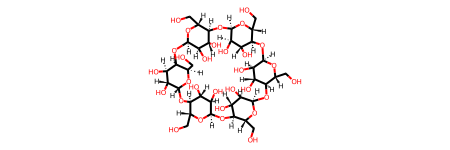

In [13]:
inchi = 'InChI=1S/C36H60O30/c37-1-7-25-13(43)19(49)31(55-7)62-26-8(2-38)57-33(21(51)15(26)45)64-28-10(4-40)59-35(23(53)17(28)47)66-30-12(6-42)60-36(24(54)18(30)48)65-29-11(5-41)58-34(22(52)16(29)46)63-27-9(3-39)56-32(61-25)20(50)14(27)44/h7-54H,1-6H2/t7-,8-,9-,10-,11-,12-,13-,14-,15-,16-,17-,18-,19-,20-,21-,22-,23-,24-,25-,26-,27-,28-,29-,30-,31-,32-,33-,34-,35-,36-/m1/s1'
smi = cirpy.resolve(inchi, 'smiles')
mol = Chem.MolFromSmiles(smi)
display(mol)

## Extracting data from ThermoML

In [14]:
import logging
logging.basicConfig(level=logging.DEBUG)

data_set = ThermoMLDataSet.from_doi('10.1021/je800307g')
# data_set.substances

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): trc.nist.gov:443
DEBUG:urllib3.connectionpool:https://trc.nist.gov:443 "GET /ThermoML/10.1021/je800307g.xml HTTP/1.1" 200 3964
DEBUG:charset_normalizer:Encoding detection: utf_8 is most likely the one.
DEBUG:charset_normalizer:Encoding detection: utf_8 is most likely the one.
DEBUG:root:An unsupported property was found ((Relative) activity) and will be skipped.
DEBUG:root:An unsupported property was found ((Relative) activity) and will be skipped.


In [15]:
data_set.to_pandas()

,Id,Temperature (K),Pressure (kPa),Phase,N Components,Component 1,Role 1,Mole Fraction 1,Exact Amount 1,Component 2,Role 2,Mole Fraction 2,Exact Amount 2,Density Value (g / ml),Density Uncertainty (g / ml),OsmoticCoefficient Value (),OsmoticCoefficient Uncertainty (),Source
0,c0d390338fef49efbae85521714a1fce,298.15,NaN,Liquid + Gas,1,O,Solvent,1.000000,None,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.00100,10.1021/je800307g
1,5d7b1cebf5e347b49592ff098a2f24b4,298.15,NaN,Liquid + Gas,2,O,Solvent,0.999638,None,CC(=O)[O-].[K+],Solvent,0.000362,NaN,NaN,NaN,0.9586,0.00125,10.1021/je800307g
2,71fe0ce4b72f405281eade09228100d7,298.15,NaN,Liquid + Gas,2,O,Solvent,0.999268,None,CC(=O)[O-].[K+],Solvent,0.000732,NaN,NaN,NaN,0.9487,0.00135,10.1021/je800307g
3,e519414eead44e72a5ffbcfa70b29a1b,298.15,NaN,Liquid + Gas,2,O,Solvent,0.998925,None,CC(=O)[O-].[K+],Solvent,0.001075,NaN,NaN,NaN,0.9442,0.00140,10.1021/je800307g
4,ecfed93a871b42029a08d55546eb0d9f,298.15,NaN,Liquid + Gas,2,O,Solvent,0.998567,None,CC(=O)[O-].[K+],Solvent,0.001433,NaN,NaN,NaN,0.9418,0.00145,10.1021/je800307g
5,2eacb81ebfad46ec8b9b79bec7c2cb13,298.15,NaN,Liquid + Gas,2,O,Solvent,0.998205,None,CC(=O)[O-].[K+],Solvent,0.001795,NaN,NaN,NaN,0.9408,0.00145,10.1021/je800307g
6,ae2228031a364ffa9076aa952f2b7ac8,298.15,NaN,Liquid + Gas,2,O,Solvent,0.997839,None,CC(=O)[O-].[K+],Solvent,0.002161,NaN,NaN,NaN,0.9409,0.00145,10.1021/je800307g
7,5a2507db776a4a4db602d42f120c506c,298.15,NaN,Liquid + Gas,2,O,Solvent,0.997478,None,CC(=O)[O-].[K+],Solvent,0.002522,NaN,NaN,NaN,0.9417,0.00145,10.1021/je800307g
8,3ce1d7cf3bf84099afdac2d89ac1c1d0,298.15,NaN,Liquid + Gas,2,O,Solvent,0.997113,None,CC(=O)[O-].[K+],Solvent,0.002887,NaN,NaN,NaN,0.9431,0.00140,10.1021/je800307g
9,acd6e2c884804ca3b9605e5d9005cb88,298.15,NaN,Liquid + Gas,2,O,Solvent,0.996752,None,CC(=O)[O-].[K+],Solvent,0.003248,NaN,NaN,NaN,0.9449,0.00140,10.1021/je800307g


In [16]:
# import logging
# logging.basicConfig(level=logging.DEBUG)

# with open('sorted_dois.json') as f:
#     doi_dat = json.load(f)
#     data_set = ThermoMLDataSet.from_doi(*doi_dat['working'])a

In [17]:
# len(data_set), data_set.property_types

In [18]:
# from openff.evaluator.datasets.curation.components.filtering import FilterByPropertyTypes, FilterByPropertyTypesSchema
# from openff.evaluator.datasets.curation.components.filtering import FilterByNComponents, FilterByNComponentsSchema

# data_set = FilterByNComponents.apply(
#     data_set, FilterByNComponentsSchema(n_components=[2])
# )

# print(len(data_set))

In [19]:
# df = data_set.to_pandas()
# df.to_csv("filtered_data_set_1.csv")

In [20]:
# liqgas = df[df['Phase'] == 'Liquid + Gas']
# liqgas

In [21]:
# df['Component 2'].unique()

In [22]:
# Chem.MolFromSmiles('CC(=O)[O-].[K+]')

## Filtering data set

In [23]:
from openff.evaluator.datasets.curation.components.filtering import FilterByPropertyTypes, FilterByPropertyTypesSchema
from openff.evaluator.datasets.curation.components.filtering import FilterByTemperature, FilterByTemperatureSchema
from openff.evaluator.datasets.curation.components.filtering import FilterByPressure, FilterByPressureSchema
from openff.evaluator.datasets.curation.components.filtering import FilterBySmiles, FilterBySmilesSchema

# Property
data_set_o = FilterByPropertyTypes.apply(
    data_set, FilterByPropertyTypesSchema(property_types=["OsmoticCoefficient"])
)
print(f"There are now {len(data_set_o)} properties after filtering")

INFO:openff.evaluator.datasets.curation.components.components:11 data points were removed after applying the FilterByPropertyTypes component.


KeyError: 'Pressure (kPa)'

In [24]:
# data_set.to_pandas()

In [25]:
# from openff.evaluator.datasets.curation.components.filtering import FilterByPropertyTypes, FilterByPropertyTypesSchema
# from openff.evaluator.datasets.curation.components.filtering import FilterByTemperature, FilterByTemperatureSchema
# from openff.evaluator.datasets.curation.components.filtering import FilterByPressure, FilterByPressureSchema
# from openff.evaluator.datasets.curation.components.filtering import FilterBySmiles, FilterBySmilesSchema

# # # Property
# # data_set = FilterByPropertyTypes.apply(
# #     data_set, FilterByPropertyTypesSchema(property_types=["Density"])
# # )

# # Temperature
# data_set = FilterByTemperature.apply(
#     data_set, FilterByTemperatureSchema(minimum_temperature=295.0, maximum_temperature=305.0)
# )

# # Pressure
# data_set = FilterByPressure.apply(
#     data_set, FilterByPressureSchema(minimum_pressure=100.0, maximum_pressure=102.0)
# )

# # # SMILES
# # data_set = FilterBySmiles.apply(
# #     data_set, FilterBySmilesSchema(smiles_to_include=["[Na+].[Cl-]"])
# # )

# print(len(data_set))

In [26]:
# pandas_data_set = data_set.to_pandas()
# pandas_data_set[
#     [
#         "Temperature (K)",
#         "Pressure (kPa)",
#         "Component 1",
#         "OsmoticCoefficient Value ()",
#         "Source",
#     ]
# ].head()

In [27]:
# pandas_data_set.to_csv("filtered_data_set.csv")
# #pandas_data_set.to_excel("filtered_data_set.csv")